In [1]:
"""
Name: example_probabilistic_model.ipynb
Authors: Stephan Meighen-Berger
Constructs a probabilistic model which can be used instead of the cpu heavy simulation
"""

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd
import imageio
from tqdm import tqdm
from scipy.interpolate import UnivariateSpline
import pickle

In [3]:
# Adding path to module
sys.path.append("../")

In [4]:
# picture path
PICS = '../pics/'

In [5]:
# Module imports
from fourth_day import Fourth_Day, config
from fourth_day.pdfs import construct_pdf

In [6]:
# Plotting standards
std_size = 6.
fontsize = 20.
lw=1.
h_length=1.

In [7]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [8]:
# Reuse sim data
config['scenario']['class'] = 'New'
config['scenario']["statistics storage"]["name"] = "probabilistic"
# Some example settings
config['scenario']['population size'] = 2
config['scenario']['duration'] = 6000
config['scenario']['organism movement'] = False
config['scenario']['exclusion'] = True
config['scenario']['injection']['rate'] = 1e-2
config['scenario']['injection']['y range'] = [4.9, 5.1]
config['scenario']['light prop'] = {
            "switch": False,
            "x_pos": 5.,
            "y_pos": 10.,
        }
config['scenario']['detector'] = {
    "switch": False,
}
# Organisms
config['organisms']['emission fraction'] = 0.1
config['organisms']['alpha'] = 10.
# Geometry
config['geometry']['volume'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    'offset': None,
}
config['geometry']['observation'] = {
    'function': 'rectangle',
    'x_length': 26.,
    'y_length': 10.,
    "offset": np.array([0., 0.]),
}
config['geometry']["exclusion"] = {
    "function": "sphere",
    "radius": 0.15,
    "x_pos": 2.,
    "y_pos": 5.,
}
# Water
config['water']['model']['name'] = 'custom' # using grid files
config['water']['model']['off set'] = np.array([0., 2.5])
config['water']['model']['directory'] = "../data/current/Long_run_corr/"
config['water']['model']['time step'] = 0.1
config['advanced']['starting step'] = 0

In [9]:
# Creating a fourth_day object
fd = Fourth_Day()

In [10]:
# Launching solver
fd.sim()

In [11]:
fd.statistics[-1]

,species,pos_x,pos_y,velocity,angle,radius,energy,observed,max_emission,emission fraction,...,pulse mean,pulse sd,pulse size,pulse start,is_emitting,emission_duration,encounter photons,shear photons,photons,is_injected
0,long pulse 1,26.002316,4.741636,0.0,0.0,0.000579,1.0000,False,10.058169,0.1,...,2.0,1.5,1.500000e+00,False,False,-2192.0,0.0,0.000000e+00,0.000000e+00,False
1,long pulse 1,26.002833,3.254552,0.0,0.0,0.001120,1.0000,False,5.947188,0.1,...,2.0,1.5,1.500000e+00,False,False,-1875.0,0.0,0.000000e+00,0.000000e+00,False
2,long pulse 1,26.008272,7.150830,0.0,0.0,0.000725,0.0569,False,6.509264,0.1,...,2.0,1.5,1.000000e+10,False,False,-468.0,0.0,0.000000e+00,0.000000e+00,True
3,long pulse 1,26.000299,7.048738,0.0,0.0,0.001030,0.0504,False,10.707564,0.1,...,2.0,1.5,1.000000e+10,False,False,-403.0,0.0,0.000000e+00,0.000000e+00,True
4,short pulse,26.002844,6.112713,0.0,0.0,0.001579,0.0400,False,13.683245,0.1,...,2.0,0.3,1.000000e+10,False,False,-294.0,0.0,0.000000e+00,0.000000e+00,True
5,long pulse 1,26.003488,5.132881,0.0,0.0,0.001102,0.0664,False,11.087622,0.1,...,2.0,1.5,1.000000e+10,False,False,-554.0,0.0,0.000000e+00,0.000000e+00,True
6,long pulse 1,26.004059,5.857947,0.0,0.0,0.000665,0.0453,False,-6.202004,0.1,...,2.0,1.5,1.000000e+10,False,False,-350.0,0.0,0.000000e+00,0.000000e+00,True
7,short pulse,26.007270,5.639771,0.0,0.0,0.001630,0.0658,False,16.241518,0.1,...,2.0,0.3,1.000000e+10,False,False,-328.0,0.0,0.000000e+00,0.000000e+00,True
8,long pulse 1,26.002697,4.974115,0.0,0.0,0.000477,0.0493,False,1.823385,0.1,...,2.0,1.5,1.000000e+10,False,False,-283.0,0.0,0.000000e+00,0.000000e+00,True
9,short pulse,26.005152,3.684048,0.0,0.0,0.001044,0.0449,False,12.685645,0.1,...,2.0,0.3,1.000000e+10,False,False,-344.0,0.0,0.000000e+00,0.000000e+00,True


In [16]:
fd.statistics[-1]["pos_y"].values[fd.statistics[-1]["pulse start"].values]

array([], dtype=float64)

In [28]:
# Analyzing data
x_loc = []
for stat in fd.statistics:
    tmp = stat["pos_x"].values[stat["pulse start"].values]
    if len(tmp) > 0:
        x_loc.append(tmp)
    else:
        continue
x_loc = np.concatenate(x_loc).ravel()

In [39]:
# Normalization
norm_fac = []
for x_l in x_loc:
    norm_fac.append(len(
        fd.statistics[-1]["pos_x"].values[np.where(fd.statistics[-1]["pos_x"].values >= x_l ) ]
    ))
norm_fac = np.array(norm_fac)

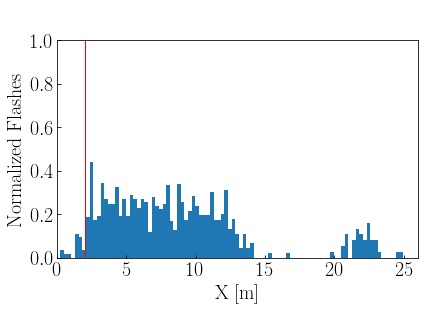

In [43]:
# Energy distributions
figure, (ax1) = plt.subplots(1, 1, figsize=(std_size, std_size * 6. / 8.), sharex=True)
ax1.hist(x_loc, bins=np.linspace(0., 26., 100), weights=1./norm_fac)
ax1.set_xscale('linear')
ax1.set_yscale('linear')
ax1.set_xlabel(r'$\mathrm{X}\;[\mathrm{m}]$', fontsize=fontsize)
ax1.set_ylabel(r'$\mathrm{Normalized\;Flashes}$', fontsize=fontsize)
ax1.tick_params(axis = 'both', which = 'major', labelsize=fontsize, direction='in')
ax1.tick_params(axis = 'both', which = 'minor', labelsize=fontsize, direction='in')
ax1.axvline(2., color='r', lw=lw)
# ax1.grid(True)
h, l = ax1.get_legend_handles_labels()
lgd1 = ax1.legend(h,l, loc=9, bbox_to_anchor=(0.5, +1.2),
                  ncol=5, fontsize=fontsize, handlelength=h_length,
                  fancybox=True, frameon=False)
ax1.set_ylim(0., 1.)
ax1.set_xlim(0., 26.)
plt.tight_layout()
plt.show()